In [308]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [309]:
PATH = "/content/drive/MyDrive/dataset"


In [310]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

warnings.simplefilter(action='ignore', category=FutureWarning)


# Prepare data

In [311]:
app_train = pd.read_csv(PATH + '/train.csv')
original_test = pd.read_csv(PATH + '/test.csv')
app_test = copy.deepcopy(original_test)
print('app_train shape',app_train.shape)
print('app_test shape',app_test.shape)

app_train shape (13293, 156)
app_test shape (4422, 155)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [312]:
app_train.isnull().sum()


index                                                 0
hashed_factory_id                                     0
country                                              67
hashed_type_of_inspection                            68
style_number                                         71
                                                     ..
factory_product_measurement_minor_defect_rate_60      0
factory_product_measurement_minor_defect_rate_90      0
factory_product_measurement_minor_defect_rate_120     0
factory_product_measurement_minor_defect_rate_150     0
label                                                 0
Length: 156, dtype: int64

In [313]:
app_train['label'].value_counts()


0    12641
1      652
Name: label, dtype: int64

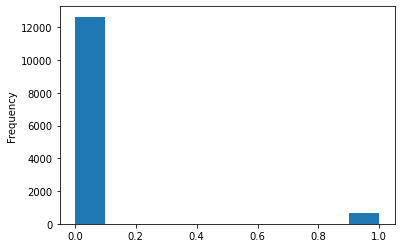

In [314]:
app_train['label'].astype(int).plot.hist();


In [315]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13293 entries, 0 to 13292
Columns: 156 entries, index to label
dtypes: float64(145), int64(2), object(9)
memory usage: 15.8+ MB


# Preprocessing data
## Remove columns with unique values 

In [316]:
app_train.drop('index',inplace=True,axis=1)
train_unique_columns = []
for col in app_train.columns:
    if len(app_train[col].unique()) == 1:
        train_unique_columns.append(col)
        app_train.drop(col,inplace=True,axis=1)
app_test.drop('index',inplace=True,axis=1)

for col in train_unique_columns:
    app_test.drop(col,inplace=True,axis=1)
print("app_train shape:", app_train.shape)
print("app_test shape:", app_test.shape)

app_train shape: (13293, 115)
app_test shape: (4422, 114)


In [317]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("lected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns

In [318]:
print("app_train missing value")
missing_values = missing_values_table(app_train)
missing_values.head(20)



app_train missing value
lected dataframe has 115 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
style_number,71,0.5
hashed_product_category,69,0.5
hashed_type_of_inspection,68,0.5
country,67,0.5
brand_number,61,0.5
item_number,59,0.4
hashed_product_line,58,0.4


In [319]:
print("app_test missing value")
missing_values = missing_values_table(app_test)
missing_values.head(20)



app_test missing value
lected dataframe has 114 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
hashed_product_line,27,0.6
hashed_type_of_inspection,24,0.5
brand_number,22,0.5
item_number,21,0.5
style_number,19,0.4
country,18,0.4
hashed_product_category,18,0.4


In [320]:
catagory_features_keep_min_freequency_from_visualize = {'country': 5,
 'hashed_factory_id': 1,
 'hashed_type_of_inspection': 134,
 'style_number': 2,
 'item_number': 2,
 'brand_number': 5,
 'hashed_product_line': 7,
 'hashed_product_category': 3,
 'hashed_product_id': 1}

## Fill NAN values and remove the values with a frequency smaller threshold and assign them with other class

In [321]:
missing_value_in_columns = missing_values.index.to_list()
for idx,column in enumerate(missing_value_in_columns):    
    app_train[column] = app_train[column].fillna('Unknown')
    app_test[column] = app_test[column].fillna('Unknown')
#     app_train[column] = app_train[column].fillna(app_train[column].value_counts().index[0])
#     app_test[column] = app_test[column].fillna(app_test[column].value_counts().index[0])
    # use_values = (app_train[column].value_counts().loc[lambda x : x>catagory_features_keep_min_freequency_from_visualize[column]]).index.tolist()
    use_values = (app_train[column].value_counts().loc[lambda x : x>8]).index.tolist()
    for i in range(app_train.shape[0]):
        if app_train[column][i] not in use_values:
            if app_train[column][i] != 'Unknown':
                app_train[column][i] = 'Other' + str(idx)
    for i in range(app_test.shape[0]):
        if app_test[column][i] not in use_values:
            if app_test[column][i] != 'Unknown':
                app_test[column][i] = 'Other' + str(idx)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [322]:
missing_values = missing_values_table(app_train)
missing_values.head(20)
app_train

lected dataframe has 115 columns.
There are 0 columns that have missing values.


,hashed_factory_id,country,hashed_type_of_inspection,style_number,item_number,brand_number,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,factory_inspection_fail_rate_90,factory_inspection_fail_rate_120,...,factory_product_packaging_major_defect_rate_60,factory_product_packaging_major_defect_rate_90,factory_product_packaging_major_defect_rate_120,factory_product_packaging_major_defect_rate_150,factory_product_packaging_minor_defect_rate_30,factory_product_packaging_minor_defect_rate_60,factory_product_packaging_minor_defect_rate_90,factory_product_packaging_minor_defect_rate_120,factory_product_packaging_minor_defect_rate_150,label
0,009f006e3799f9fe96a0c95e944df3e669f02d4e,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.000000,0.032258,0.028571,0.027778,...,0.004545,0.004545,0.004545,0.004545,0.0,0.0,0.0,0.0,0.0,0
1,a9f2640fbd054cb52bf9411b7a42f668a9613197,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,5,1.0,0.000000,0.200000,0.035714,0.020408,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
2,c0bffcf0318c483b2dbb1c56bed6efa58f9717bd,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,8,Unknown,0.000000,0.000000,0.000000,0.000000,...,0.000444,0.000400,0.000400,0.000400,0.0,0.0,0.0,0.0,0.0,0
3,c96f3f1c47dca83af551893a28c3409cb4afd31d,Guatemala,e06d28d1365467625ebfa999328501705a3398bb,2,12,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
4,63ffdba896c8bb150eca939d1eb7e3bd4e732ed4,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,2,1.0,0.000000,0.000000,0.000000,0.100000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13288,009f006e3799f9fe96a0c95e944df3e669f02d4e,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,15,1.0,0.000000,0.000000,0.022222,0.021277,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
13289,9213adcfaa233c1bd362eeaaef15269b1f15afe1,Nicaragua,e06d28d1365467625ebfa999328501705a3398bb,1,18,1.0,0.015385,0.009174,0.012195,0.010870,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
13290,5a06094857c4e9b5bd124cf37a6e7d336bb8edd4,Cambodia,e06d28d1365467625ebfa999328501705a3398bb,3,20,1.0,0.071429,0.053571,0.045977,0.039604,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
13291,a9f2640fbd054cb52bf9411b7a42f668a9613197,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,9,33,1.0,0.000000,0.000000,0.023529,0.018868,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0


In [323]:
missing_values = missing_values_table(app_test)
missing_values.head(20)
app_test

lected dataframe has 114 columns.
There are 0 columns that have missing values.


,hashed_factory_id,country,hashed_type_of_inspection,style_number,item_number,brand_number,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,factory_inspection_fail_rate_90,factory_inspection_fail_rate_120,...,factory_product_packaging_major_defect_rate_30,factory_product_packaging_major_defect_rate_60,factory_product_packaging_major_defect_rate_90,factory_product_packaging_major_defect_rate_120,factory_product_packaging_major_defect_rate_150,factory_product_packaging_minor_defect_rate_30,factory_product_packaging_minor_defect_rate_60,factory_product_packaging_minor_defect_rate_90,factory_product_packaging_minor_defect_rate_120,factory_product_packaging_minor_defect_rate_150
0,57e6f82ac38828e1c4cc9a6ff415a5ad2fa94507,China,e06d28d1365467625ebfa999328501705a3398bb,1,20,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,67bc0575f067a61d385539a2169c649814accea7,Nicaragua,4a31b54c7b1ada762e54a711dc598073de477352,1,18,1.0,0.031250,0.032258,0.071429,0.070175,...,0.000333,0.000161,0.000094,0.000085,0.000085,0.0,0.0,0.0,0.0,0.0
2,ab1e388558d6ea7093a4f7912cd1381e2a2962ae,China,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,8e0114f5d7c26b37cec7f58a197a93bbc49e14a6,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,10,1.0,0.007407,0.003937,0.002865,0.002331,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,52ef0901f440dc5f007c4f8d79eff436d79da852,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,7,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,b6f1eddfb2a0695fe5d8cd3fdb8f5e5db2d0efc3,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,2,Other3,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4418,864a334df4c3602dc835dfba496cde1056374bbd,China,e06d28d1365467625ebfa999328501705a3398bb,1,Other3,1.0,0.000000,0.000000,0.000000,0.009009,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4419,cd2bf6a940623a271e2e425d95d7689c2db69e9f,China,e06d28d1365467625ebfa999328501705a3398bb,2,Unknown,1.0,0.055556,0.031250,0.025641,0.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4420,cd2bf6a940623a271e2e425d95d7689c2db69e9f,China,e06d28d1365467625ebfa999328501705a3398bb,2,Other3,1.0,0.055556,0.031250,0.025641,0.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [324]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13293 entries, 0 to 13292
Columns: 115 entries, hashed_factory_id to label
dtypes: float64(105), int64(1), object(9)
memory usage: 11.7+ MB


In [325]:
app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4422 entries, 0 to 4421
Columns: 114 entries, hashed_factory_id to factory_product_packaging_minor_defect_rate_150
dtypes: float64(105), object(9)
memory usage: 3.8+ MB


In [326]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
app_test.select_dtypes('object').apply(pd.Series.nunique, axis = 0)


hashed_factory_id            266
country                       16
hashed_type_of_inspection      7
style_number                  13
item_number                   80
brand_number                   5
hashed_product_line            4
hashed_product_category       35
hashed_product_id            103
dtype: int64

## Remove the correlated features

In [327]:
# Create correlation matrix
corr_matrix = app_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
app_train.drop(to_drop, axis=1, inplace=True)
app_test.drop(to_drop, axis=1, inplace=True)
print("training shape", app_train.shape)
print("testing shape", app_test.shape)


training shape (13293, 46)
testing shape (4422, 45)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [328]:
labels =  app_train['label']
app_train = app_train.drop('label', axis=1)
print("training shape", app_train.shape)


training shape (13293, 45)


# Using Categorical Data with One Hot Encoding


In [329]:

object_cols = app_train.select_dtypes(include = "object").columns.to_list()
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(app_train[object_cols]))
# OH_cols_test = pd.DataFrame(OH_encoder.transform(app_test[object_cols].astype(str)))
OH_cols_test = pd.DataFrame(OH_encoder.transform(app_test[object_cols]))
# One-hot encoding removed index; put it back
OH_cols_train.index = app_train.index
OH_cols_test.index = app_test.index
# Remove categorical columns (will replace with one-hot encoding)
num_X_train = app_train.drop(object_cols, axis=1)
num_X_test = app_test.drop(object_cols, axis=1)
# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)
data = OH_X_train
app_test = OH_X_test
print(data.shape)
print(app_test.shape)

(13293, 648)
(4422, 648)


# Transform data


In [330]:
features = list(data.columns)
# imputer = SimpleImputer(strategy = 'median')
# Imputation transformer for completing missing values. 
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# Min-Max Scaler: xi–min(x)/max(x)–min(x)
scaler = MinMaxScaler(feature_range = (0, 1))
imputer.fit(data)
data = imputer.transform(data)
app_test = imputer.transform(app_test)
scaler.fit(data)
data = scaler.transform(data)
app_test = scaler.transform(app_test)
print('Training data shape: ', data.shape)
print('Testing data shape: ', app_test.shape)
data

Training data shape:  (13293, 648)
Testing data shape:  (4422, 648)


array([[0.        , 0.03225806, 0.02857143, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.2       , 0.03571429, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07142857, 0.05357143, 0.04597701, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.02352941, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02352941, ..., 0.        , 0.        ,
        0.        ]])

In [331]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=11)

In [332]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Define data loader for training and validation

In [333]:
EPOCHS = 25
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train.astype(int)))
val_data = TrainData(torch.FloatTensor(X_val), 
                       torch.FloatTensor(y_val.values.astype(int)))


In [334]:
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(app_test))

In [335]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

# ANN model design

In [336]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(648, 128) 
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.dropout1 = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
#         x = F.sigmoid(x)
        return x

# Loss function and optimizer

In [337]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
# criterion = F1_Loss().cuda()
# criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=648, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [338]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

# Training step and evaluation to choose the best model

In [339]:


import numpy as np 
def sigmoid(x):
    return 1/(1 + np.exp(-x))

from sklearn.metrics import f1_score
model.train()
best_f1 = 0
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    model.eval()
    list_grouth_truth = []
    list_pred = []
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        # data, target = data, target.to(device)
        list_grouth_truth.append(target.cpu().detach().numpy()[0])
        output = model(data)
        y_test_pred = torch.sigmoid(output)
        list_pred.append(y_test_pred.cpu().detach().numpy()[0][0])
#         acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
    precision, recall, thresholds = precision_recall_curve(list_grouth_truth, list_pred)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = -1
    max_score = 0
    for idx, score in enumerate(fscore):
        if score > max_score:
            max_score = score
            ix = idx
    print('threshold: ', thresholds[ix], 'Best_fscore:',fscore[ix])
    print('current fscore {}, best fscore {}'.format(fscore[ix], best_f1) )

    temp = copy.deepcopy(np.array(list_pred))
    temp[temp>=float(thresholds[ix])] = 1
    temp[temp<thresholds[ix]] = 0
    print(classification_report(list_grouth_truth, temp))

    if fscore[ix] > best_f1:
        best_f1 = fscore[ix]
        print('Save model here')
        torch.save(model.state_dict(), PATH +'/save_model/best_ann.pt')
    model.train()
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


threshold:  0.47187093 Best_fscore: 0.23781676413255362
current fscore 0.23781676413255362, best fscore 0
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92      2513
         1.0       0.17      0.42      0.24       146

    accuracy                           0.85      2659
   macro avg       0.56      0.65      0.58      2659
weighted avg       0.92      0.85      0.88      2659

Save model here
Epoch 001: | Loss: 0.65087 | Acc: 63.563


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


threshold:  0.28835505 Best_fscore: 0.21016949152542372
current fscore 0.21016949152542372, best fscore 0.23781676413255362
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90      2513
         1.0       0.14      0.42      0.21       146

    accuracy                           0.82      2659
   macro avg       0.55      0.64      0.56      2659
weighted avg       0.92      0.82      0.86      2659

Epoch 002: | Loss: 0.44430 | Acc: 86.473


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


threshold:  0.22869271 Best_fscore: 0.2565597667638484
current fscore 0.2565597667638484, best fscore 0.23781676413255362
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      2513
         1.0       0.22      0.30      0.26       146

    accuracy                           0.90      2659
   macro avg       0.59      0.62      0.60      2659
weighted avg       0.92      0.90      0.91      2659

Save model here
Epoch 003: | Loss: 0.26857 | Acc: 93.509
threshold:  0.20510823 Best_fscore: 0.28461538461538466
current fscore 0.28461538461538466, best fscore 0.2565597667638484
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      2513
         1.0       0.32      0.25      0.28       146

    accuracy                           0.93      2659
   macro avg       0.64      0.61      0.62      2659
weighted avg       0.92      0.93      0.93      2659

Save model here
Epoch 004: | Loss: 0.19800 |

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


threshold:  0.116003215 Best_fscore: 0.25136612021857924
current fscore 0.25136612021857924, best fscore 0.28461538461538466
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94      2513
         1.0       0.21      0.32      0.25       146

    accuracy                           0.90      2659
   macro avg       0.58      0.62      0.60      2659
weighted avg       0.92      0.90      0.91      2659

Epoch 005: | Loss: 0.16857 | Acc: 94.886


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


threshold:  0.17307179 Best_fscore: 0.2765273311897106
current fscore 0.2765273311897106, best fscore 0.28461538461538466
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      2513
         1.0       0.26      0.29      0.28       146

    accuracy                           0.92      2659
   macro avg       0.61      0.62      0.62      2659
weighted avg       0.92      0.92      0.92      2659

Epoch 006: | Loss: 0.15690 | Acc: 94.904
threshold:  0.10229925 Best_fscore: 0.28776978417266186
current fscore 0.28776978417266186, best fscore 0.28461538461538466
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      2513
         1.0       0.22      0.41      0.29       146

    accuracy                           0.89      2659
   macro avg       0.59      0.66      0.61      2659
weighted avg       0.92      0.89      0.90      2659

Save model here
Epoch 007: | Loss: 0.13883 | Acc: 95.521
th

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


threshold:  0.05226486 Best_fscore: 0.25995807127882603
current fscore 0.25995807127882603, best fscore 0.29444444444444445
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.93      2513
         1.0       0.19      0.42      0.26       146

    accuracy                           0.87      2659
   macro avg       0.58      0.66      0.59      2659
weighted avg       0.92      0.87      0.89      2659

Epoch 014: | Loss: 0.10647 | Acc: 95.790
threshold:  0.07718736 Best_fscore: 0.2577777777777778
current fscore 0.2577777777777778, best fscore 0.29444444444444445
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93      2513
         1.0       0.19      0.40      0.26       146

    accuracy                           0.87      2659
   macro avg       0.58      0.65      0.59      2659
weighted avg       0.92      0.87      0.89      2659

Epoch 015: | Loss: 0.09897 | Acc: 96.186
threshold:  0.0554

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


threshold:  0.057407815 Best_fscore: 0.24215246636771298
current fscore 0.24215246636771298, best fscore 0.29444444444444445
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93      2513
         1.0       0.18      0.37      0.24       146

    accuracy                           0.87      2659
   macro avg       0.57      0.64      0.59      2659
weighted avg       0.92      0.87      0.89      2659

Epoch 023: | Loss: 0.07373 | Acc: 97.090


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


threshold:  0.04173395 Best_fscore: 0.24489795918367346
current fscore 0.24489795918367346, best fscore 0.29444444444444445
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92      2513
         1.0       0.17      0.41      0.24       146

    accuracy                           0.86      2659
   macro avg       0.57      0.65      0.58      2659
weighted avg       0.92      0.86      0.89      2659

Epoch 024: | Loss: 0.07296 | Acc: 97.168
threshold:  0.039950095 Best_fscore: 0.24430641821946167
current fscore 0.24430641821946167, best fscore 0.29444444444444445
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92      2513
         1.0       0.18      0.40      0.24       146

    accuracy                           0.86      2659
   macro avg       0.57      0.65      0.58      2659
weighted avg       0.92      0.86      0.89      2659

Epoch 025: | Loss: 0.07372 | Acc: 96.952


# Loading the best model, evaluation, and save to CSV file

In [340]:
model = BinaryClassification()
model.load_state_dict(torch.load(PATH + '/save_model/best_ann.pt', map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)
y_pred_list = []
y_ground_truth = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_ground_truth.append(y_batch.cpu().detach().numpy()[0])
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_list.append(y_test_pred.cpu().numpy()[0][0])
        


In [341]:
precision, recall, thresholds = precision_recall_curve(y_ground_truth, y_pred_list)
fscore = (2 * precision * recall) / (precision + recall)

ix = -1
max_score = 0
for idx, score in enumerate(fscore):
    if score > max_score:
        max_score = score
        ix = idx
print('threshold: ', thresholds[ix], 'Best_fscore:',fscore[ix])
temp = copy.deepcopy(np.array(y_pred_list))
temp[temp>=float(thresholds[ix])] = 1
temp[temp<thresholds[ix]] = 0
print(classification_report(y_ground_truth, temp))

threshold:  0.099080645 Best_fscore: 0.29444444444444445
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      2513
         1.0       0.25      0.36      0.29       146

    accuracy                           0.90      2659
   macro avg       0.60      0.65      0.62      2659
weighted avg       0.92      0.90      0.91      2659



In [342]:
y_pred_list = []
with torch.no_grad():
    for X_batch in app_test:
        X_batch = torch.from_numpy(X_batch).to(device)
        X_batch = X_batch.unsqueeze(0)
        y_test_pred = model(X_batch.float())
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_list.append(y_test_pred.cpu().numpy()[0][0])
        


In [343]:
temp = copy.deepcopy(np.array(y_pred_list))
temp[temp>=float(thresholds[ix])] = 1
temp[temp<thresholds[ix]] = 0

In [344]:
submit = original_test
submit['TARGET'] = temp
submit.to_csv(PATH + '/ANN_Pytorch' + '.csv', index = False)

0.0    4032
1.0     390
Name: TARGET, dtype: int64

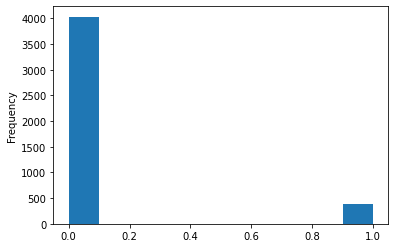

In [345]:
submit['TARGET'].astype(int).plot.hist();
submit['TARGET'].value_counts()